## Compare Data Completeness Over Time

**Description**: Analyze the trend of missing data in `"sales_data.csv"` over several months stored in a "date" column. Visualize missing data rates by month.

Error: 'sales_data.csv' not found. Please make sure the file is in the same directory.
Created a dummy DataFrame for demonstration.
Date column converted to datetime.

Monthly Missing Data Rates:
  month_year_dt  missing_data_rate
0    2024-01-01                0.0
1    2024-02-01               25.0
2    2024-03-01               25.0
3    2024-04-01                0.0


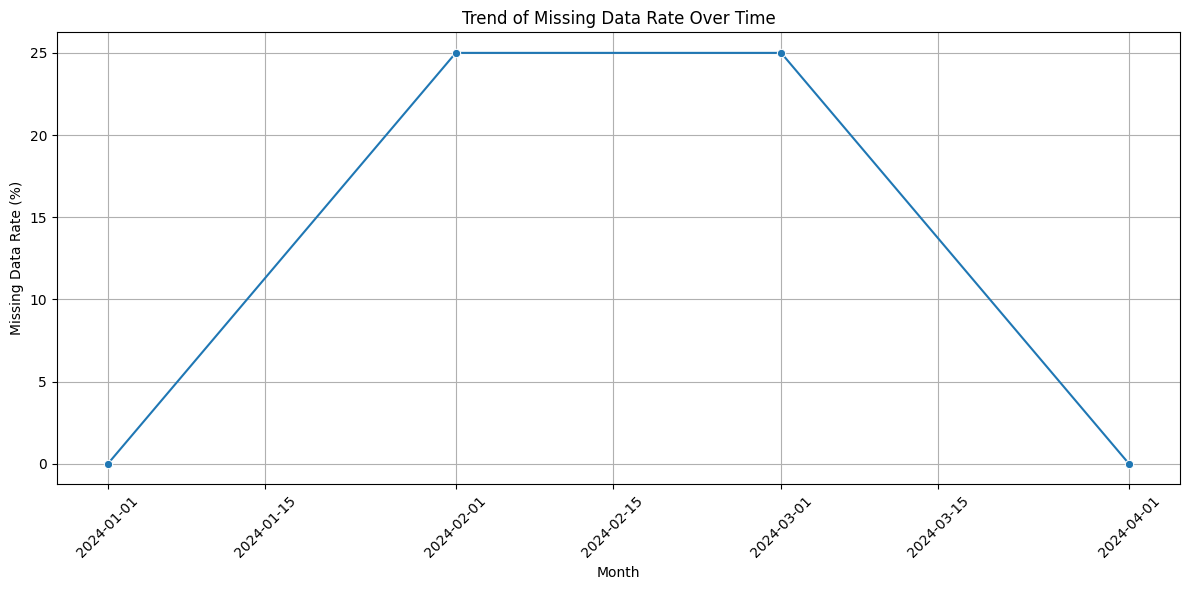


Missing values by column (Overall):
product_id      0
sales_amount    2
region          1
customer_id     1
dtype: int64

Percentage of missing values by column (Overall):
product_id       0.0
sales_amount    25.0
region          12.5
customer_id     12.5
dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the data ---
try:
    df = pd.read_csv("sales_data.csv")
    print("CSV loaded successfully.")
except FileNotFoundError:
    print("Error: 'sales_data.csv' not found. Please make sure the file is in the same directory.")
    # Create a dummy DataFrame for demonstration if the file is not found
    # In a real scenario, you'd want to ensure the file exists.
    data = {
        'date': pd.to_datetime(['2024-01-15', '2024-01-20', '2024-02-10', '2024-02-25', '2024-03-05', '2024-03-10', '2024-04-01', '2024-04-15']),
        'product_id': ['A101', 'A102', 'B201', 'A101', 'C301', 'B202', 'A103', 'C302'],
        'sales_amount': [100, 150, None, 120, 200, None, 180, 250],
        'region': ['East', 'West', 'North', 'East', None, 'South', 'West', 'North'],
        'customer_id': ['C001', 'C002', 'C003', None, 'C005', 'C006', 'C007', 'C008']
    }
    df = pd.DataFrame(data)
    print("Created a dummy DataFrame for demonstration.")

# --- 2. Convert 'date' column to datetime ---
# It's good practice to handle potential errors during conversion
try:
    df['date'] = pd.to_datetime(df['date'])
    print("Date column converted to datetime.")
except KeyError:
    print("Error: 'date' column not found. Please check your CSV header.")
    exit() # Exit if the date column is crucial and missing
except Exception as e:
    print(f"Error converting 'date' column: {e}")
    exit()

# Extract month and year for grouping
df['month_year'] = df['date'].dt.to_period('M')

# --- 3. Calculate missing data per row (or per column for a different perspective) ---
# For data completeness *over time*, we're interested in the percentage of missing values per month.
# Let's count missing values per row, then sum them up per month.
# Alternatively, we can calculate the total number of expected data points per month
# and compare it to the actual non-missing data points.

# Calculate the number of missing values per row
df['missing_values_per_row'] = df.isnull().sum(axis=1)

# --- 4. Group by month and year and calculate total missing values for each month ---
monthly_missing_data = df.groupby('month_year')['missing_values_per_row'].sum().reset_index()

# To calculate the rate, we need the total number of cells expected for each month.
# Number of rows per month * Number of columns (excluding 'date' and 'month_year' themselves if not relevant for 'completeness' check)
# Let's assume all columns except 'date' and 'month_year' contribute to the "data completeness"
data_columns = df.drop(columns=['date', 'month_year', 'missing_values_per_row']).columns
num_data_columns = len(data_columns)

rows_per_month = df.groupby('month_year').size().reset_index(name='num_rows')

# Merge to get rows count and missing values count together
monthly_completeness = pd.merge(monthly_missing_data, rows_per_month, on='month_year')

# Calculate total possible data points for each month
monthly_completeness['total_possible_data_points'] = monthly_completeness['num_rows'] * num_data_columns

# --- 5. Calculate missing data rate ---
# Percentage of missing data = (Total missing values / Total possible data points) * 100
monthly_completeness['missing_data_rate'] = (monthly_completeness['missing_values_per_row'] / monthly_completeness['total_possible_data_points']) * 100

# Convert 'month_year' back to datetime for better plotting
monthly_completeness['month_year_dt'] = monthly_completeness['month_year'].dt.to_timestamp()

print("\nMonthly Missing Data Rates:")
print(monthly_completeness[['month_year_dt', 'missing_data_rate']].sort_values(by='month_year_dt'))


# --- 6. Visualize the trend ---
plt.figure(figsize=(12, 6))
sns.lineplot(x='month_year_dt', y='missing_data_rate', data=monthly_completeness, marker='o')
plt.title('Trend of Missing Data Rate Over Time')
plt.xlabel('Month')
plt.ylabel('Missing Data Rate (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Display a breakdown of missing values by column for the entire dataset
print("\nMissing values by column (Overall):")
print(df[data_columns].isnull().sum())

print("\nPercentage of missing values by column (Overall):")
print((df[data_columns].isnull().sum() / len(df)) * 100)